In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
data = pd.read_csv('./Asset/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

,Open,High,Low,Close,Volume,7ma,14ma,21ma,7macd,14macd,...,21rsv,SQUARE_PHARMA,LHBL,RAK_CERAMIC,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
6/13/2010,327.9,334.0,321.5,330.6,4282600,327.329956,336.804907,347.692319,11.605171,22.988244,...,11.348898,2953.00,512.75,207.8,218.213045,235.579445,223.832615,215.373199,222.749952,228.204727
6/15/2010,330.0,332.6,326.0,326.9,1223300,327.648100,334.651686,344.306797,7.899987,21.585224,...,8.949416,3086.00,539.25,183.9,218.516951,236.698479,226.283623,221.922412,243.420415,253.514806
6/16/2010,330.0,331.0,323.0,324.6,2334600,326.886075,333.311461,342.515232,6.833465,20.791082,...,8.098592,3105.75,539.00,172.8,218.666063,237.253956,227.509335,225.200437,253.331452,265.187952
6/17/2010,328.5,332.9,324.1,325.6,4229700,326.564556,332.283266,340.977454,5.926798,19.940657,...,9.077705,3063.25,549.25,191.2,218.813278,237.806674,228.734885,228.476537,262.817993,275.974472
6/20/2010,325.0,328.0,315.0,318.1,2376500,324.448417,330.392164,338.897650,5.760500,19.208467,...,26.315789,3086.50,568.75,185.9,218.958592,238.356581,229.960046,231.747557,271.783336,285.732230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/19/2022,134.0,136.8,130.2,132.1,4006075,138.500265,141.664390,143.414046,3.394933,2.286910,...,0.000000,221.90,71.10,41.0,189.146478,165.763765,129.426395,146.379049,138.755841,140.131891
5/22/2022,135.9,135.9,125.5,125.9,2755183,135.350199,139.562471,141.821860,4.494766,2.844877,...,0.000000,220.10,70.50,41.0,189.485512,166.324694,129.640487,146.085557,138.733882,138.623355
5/23/2022,130.0,134.9,129.0,131.1,3735651,134.287649,138.434142,140.847145,4.932650,3.340159,...,22.608696,220.90,69.30,42.6,189.823273,166.887685,129.865577,145.766696,138.683857,137.038797


In [3]:
data['y'] = data['Close']

x = data.iloc[:, :34].values
y = data.iloc[:, 34].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split - 20:, :]
train_y, test_y = y[: split, ], y[split - 20: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2132, 34) trainY: (2132,)
testX: (553, 34) testY: (553,)


In [4]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [5]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([34, 400, 400, 400, 10], 10)

[1/300] Loss: 683.2272701263428
[2/300] Loss: 653.089916229248
[3/300] Loss: 643.1681690216064
[4/300] Loss: 635.1968040466309
[5/300] Loss: 630.7861003875732
[6/300] Loss: 626.6614952087402
[7/300] Loss: 617.7768287658691
[8/300] Loss: 610.1806221008301
[9/300] Loss: 608.0552215576172
[10/300] Loss: 603.8719348907471
[11/300] Loss: 595.6902389526367
[12/300] Loss: 591.0702819824219
[13/300] Loss: 593.3718700408936
[14/300] Loss: 582.4046573638916
[15/300] Loss: 570.4557285308838
[16/300] Loss: 576.545000076294
[17/300] Loss: 581.8065586090088
[18/300] Loss: 575.7318992614746
[19/300] Loss: 560.3889083862305
[20/300] Loss: 544.8926849365234
[21/300] Loss: 537.6335926055908
[22/300] Loss: 541.0580310821533
[23/300] Loss: 545.4905395507812
[24/300] Loss: 536.3360347747803
[25/300] Loss: 518.0625991821289
[26/300] Loss: 505.4318733215332
[27/300] Loss: 501.83726501464844
[28/300] Loss: 502.1143321990967
[29/300] Loss: 501.7342586517334
[30/300] Loss: 499.2152042388916
[31/300] Loss: 494.5

[244/300] Loss: 35.64629316329956
[245/300] Loss: 36.251189827919006
[246/300] Loss: 36.839186906814575
[247/300] Loss: 37.27315545082092
[248/300] Loss: 37.4551659822464
[249/300] Loss: 37.28768253326416
[250/300] Loss: 36.80703008174896
[251/300] Loss: 36.03299283981323
[252/300] Loss: 35.12725782394409
[253/300] Loss: 34.198277711868286
[254/300] Loss: 33.45585119724274
[255/300] Loss: 33.00672125816345
[256/300] Loss: 32.89711534976959
[257/300] Loss: 33.16498267650604
[258/300] Loss: 33.738781094551086
[259/300] Loss: 34.50279200077057
[260/300] Loss: 35.36129546165466
[261/300] Loss: 36.1121141910553
[262/300] Loss: 36.66606068611145
[263/300] Loss: 36.843660950660706
[264/300] Loss: 36.62287104129791
[265/300] Loss: 36.05276715755463
[266/300] Loss: 35.15714228153229
[267/300] Loss: 34.14943969249725
[268/300] Loss: 33.18590712547302
[269/300] Loss: 32.440537452697754
[270/300] Loss: 32.106653451919556
[271/300] Loss: 32.150596022605896
[272/300] Loss: 32.65579426288605
[273/300

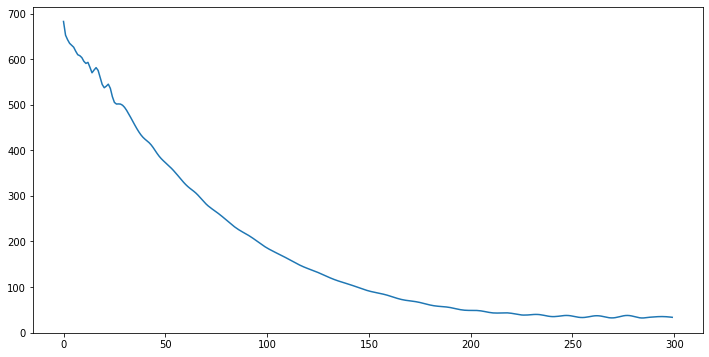

In [6]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [7]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [8]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [10]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2129, 3, 44]) train_y: torch.Size([2129, 1]) train_y_gan: torch.Size([2129, 4, 1])
test_x: torch.Size([550, 3, 44]) test_y: torch.Size([550, 1]) test_y_gan: torch.Size([550, 4, 1])


In [11]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [12]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(44).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/100] LossD: -0.0026031211018562317 LossG:-0.4143953211605549
[2/100] LossD: -0.004484161734580994 LossG:-0.3787665404379368
[3/100] LossD: -0.005998171865940094 LossG:-0.34124778397381306
[4/100] LossD: -0.006870932877063751 LossG:-0.303426556289196
[5/100] LossD: -0.006860591471195221 LossG:-0.2618635902181268
[6/100] LossD: -0.006243273615837097 LossG:-0.22530885133892298
[7/100] LossD: -0.0052210865542292595 LossG:-0.18363375589251518
[8/100] LossD: -0.00412990665063262 LossG:-0.14692659629508853
[9/100] LossD: -0.0032982896082103252 LossG:-0.11536605888977647
[10/100] LossD: -0.002847512951120734 LossG:-0.09833735460415483
[11/100] LossD: -0.0026903587859123945 LossG:-0.09339303034357727
[12/100] LossD: -0.0027083803433924913 LossG:-0.07862425572238863
[13/100] LossD: -0.002936813747510314 LossG:-0.07012647320516407
[14/100] LossD: -0.0031689500901848078 LossG:-0.06574004143476486
[15/100] LossD: -0.0034562174696475267 LossG:-0.05651208711788058
[16/100] LossD: -0.00376005657017

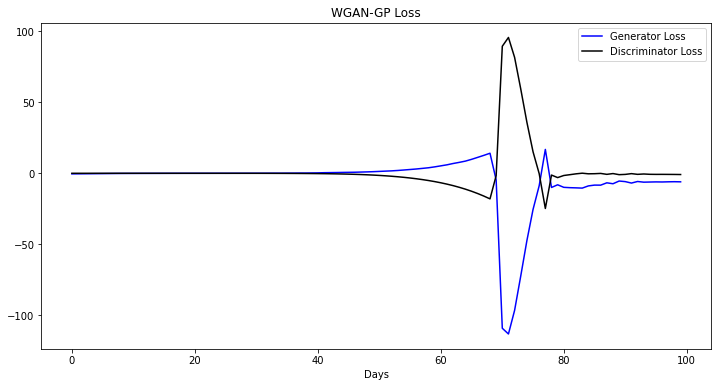

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [14]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:12.420737622689265


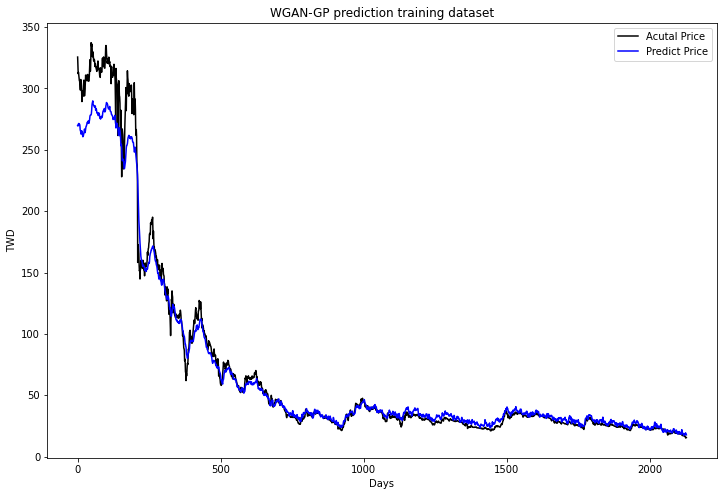

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:13.247327827526204


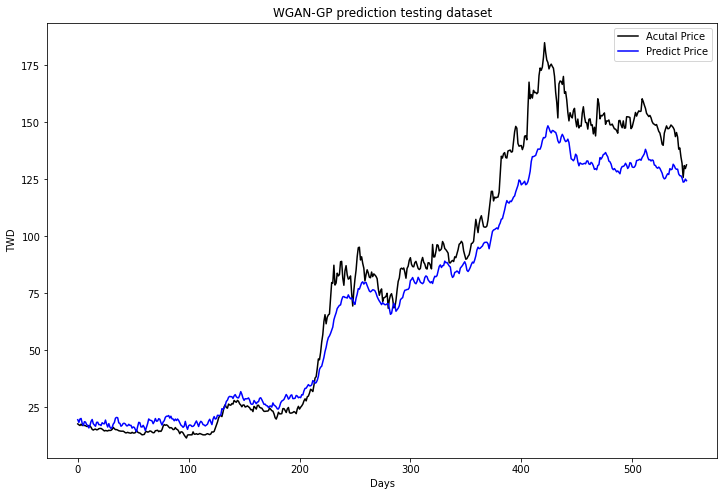

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')